In [1]:
#https://www.tensorflow.org/tutorials/images/transfer_learning

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical CPU, 1 Logical CPU


In [3]:
# train과 validation으로 이미지 나누기
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# train_dataset
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
# validation_dataset
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


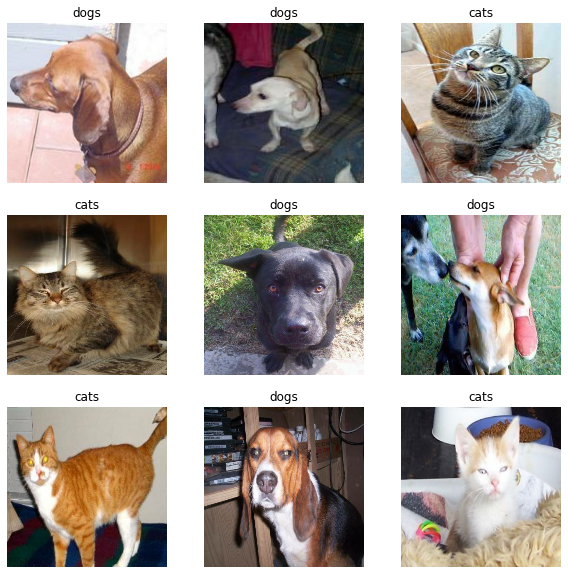

In [5]:
# 이미지 시각화
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [8]:
# data generator
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

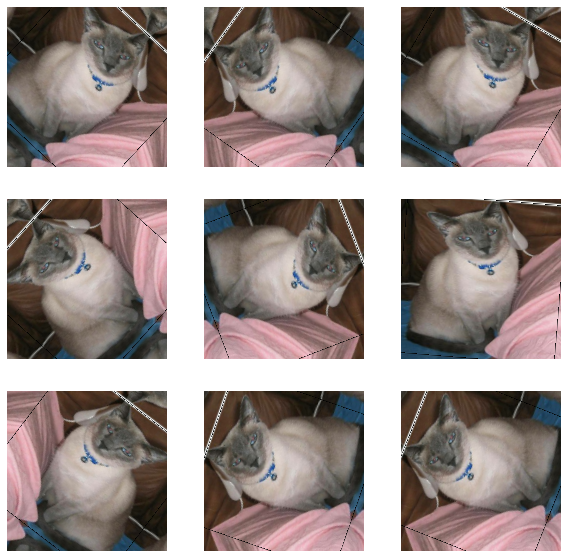

In [9]:
# data generator 결과 시각화
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [17]:
# 모델 freeze
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
inputs = tf.keras.Input(shape=(160, 160, 3))
# 입력 size 설정 및 augmentation
x = data_augmentation(inputs)
x = preprocess_input(x)
# base_model : 전이학습 모델
x = base_model(x, training=False)
# 뒤에 layer 추가
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [28]:
len(model.trainable_variables)

2

In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 8s 297ms/step - loss: 0.7321 - accuracy: 0.5545


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.73
initial accuracy: 0.55


In [31]:
import pandas as pd
pd.set_option('max_colwidth',-1)
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\User\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000247FF72EE88>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x00000247FF89A548>,Conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000247FF7825C8>,Conv1,False
3,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000247FF77EC48>,bn_Conv1,False
4,<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x00000247FF7BEE48>,Conv1_relu,False
...,...,...,...
150,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024782C7B388>,block_16_project,False
151,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024782CB2E08>,block_16_project_BN,False
152,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024782CBAB08>,Conv_1,False
153,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024782CFCC08>,Conv_1_bn,False


In [32]:
# 모든 layer freeze 한 상태로 train 데이터셋 학습
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 29s 463ms/step - loss: 0.6495 - accuracy: 0.6335 - val_loss: 0.5185 - val_accuracy: 0.7054
Epoch 2/10
63/63 [==============================] - 24s 375ms/step - loss: 0.5201 - accuracy: 0.7210 - val_loss: 0.3834 - val_accuracy: 0.7921
Epoch 3/10
63/63 [==============================] - 24s 375ms/step - loss: 0.4067 - accuracy: 0.8035 - val_loss: 0.3056 - val_accuracy: 0.8540
Epoch 4/10
63/63 [==============================] - 24s 377ms/step - loss: 0.3575 - accuracy: 0.8345 - val_loss: 0.2514 - val_accuracy: 0.8985
Epoch 5/10
63/63 [==============================] - 23s 370ms/step - loss: 0.3156 - accuracy: 0.8525 - val_loss: 0.2098 - val_accuracy: 0.9208
Epoch 6/10
63/63 [==============================] - 23s 371ms/step - loss: 0.2923 - accuracy: 0.8655 - val_loss: 0.1850 - val_accuracy: 0.9319
Epoch 7/10
63/63 [==============================] - 24s 374ms/step - loss: 0.2627 - accuracy: 0.8870 - val_loss: 0.1712 - val_accuracy: 0.9356

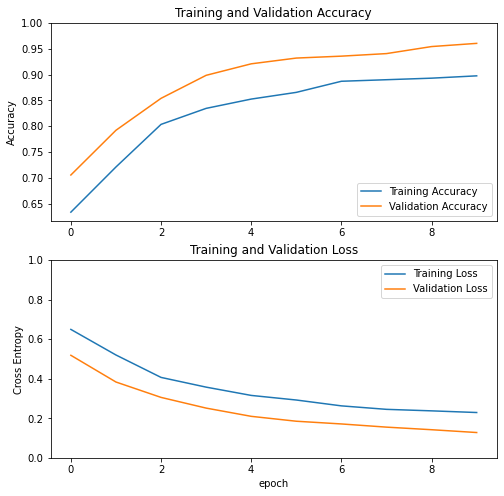

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
base_model.trainable = True

In [35]:
import pandas as pd
pd.set_option('max_colwidth',-1)
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\User\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000247FF72EE88>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x00000247FF89A548>,Conv1_pad,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000247FF7825C8>,Conv1,True
3,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000247FF77EC48>,bn_Conv1,True
4,<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x00000247FF7BEE48>,Conv1_relu,True
...,...,...,...
150,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024782C7B388>,block_16_project,True
151,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024782CB2E08>,block_16_project_BN,True
152,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024782CBAB08>,Conv_1,True
153,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024782CFCC08>,Conv_1_bn,True


In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [39]:
len(model.trainable_variables)

58

In [40]:
# 모든 layer 재학습(trainable=True)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 32s 507ms/step - loss: 0.1540 - accuracy: 0.9375 - val_loss: 0.0655 - val_accuracy: 0.9864
Epoch 11/20
63/63 [==============================] - 31s 493ms/step - loss: 0.1326 - accuracy: 0.9490 - val_loss: 0.0664 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 31s 495ms/step - loss: 0.1152 - accuracy: 0.9540 - val_loss: 0.0462 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 31s 496ms/step - loss: 0.0968 - accuracy: 0.9595 - val_loss: 0.0457 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 31s 496ms/step - loss: 0.0977 - accuracy: 0.9585 - val_loss: 0.0452 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 31s 496ms/step - loss: 0.0919 - accuracy: 0.9655 - val_loss: 0.0584 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 31s 495ms/step - loss: 0.0767 - accuracy: 0.9640 - val_loss: 0.0466 - val_accuracy:

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

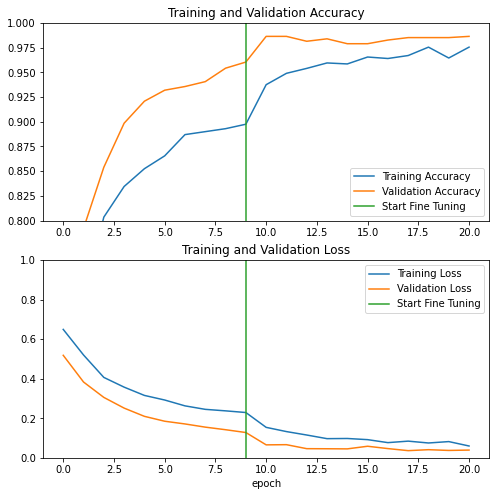

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 224ms/step - loss: 0.0483 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


Predictions:
 [0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0]
Labels:
 [0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0]


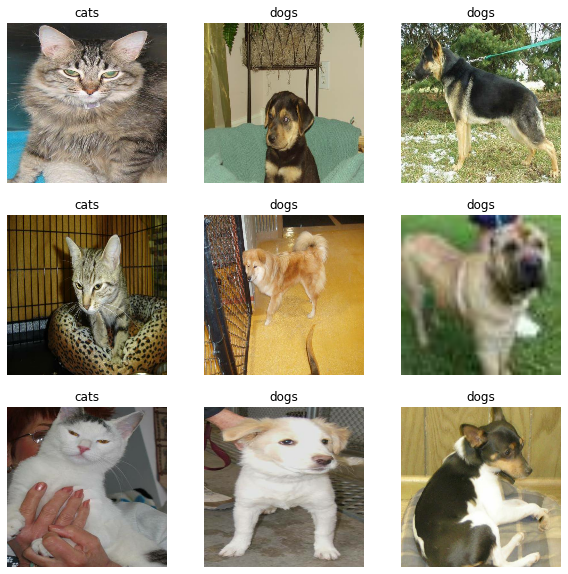

In [44]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")